<a href="https://colab.research.google.com/github/tupoylogin/dge-ann/blob/master/notebooks/NodeAttentionNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install --quiet tensorflow-recommenders tensorflow-ranking tensorflow-addons kaggle hydra hydra-core

     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 141 kB 24.3 MB/s 
     |████████████████████████████████| 1.1 MB 62.3 MB/s 
     |████████████████████████████████| 82 kB 775 kB/s 
     |████████████████████████████████| 151 kB 81.8 MB/s 
     |████████████████████████████████| 462 kB 73.2 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 117 kB 100.6 MB/s 
     |████████████████████████████████| 596 kB 56.7 MB/s 


In [2]:
! git clone https://github.com/tupoylogin/dge-ann

Cloning into 'dge-ann'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 185 (delta 61), reused 69 (delta 33), pack-reused 88
Receiving objects: 100% (185/185), 66.37 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! kaggle datasets download -d mkechinov/ecommerce-events-history-in-electronics-store
! unzip /content/ecommerce-events-history-in-electronics-store.zip
! cp events.csv dge-ann/data/raw/events.csv

 84% 17.0M/20.3M [00:01<00:00, 13.6MB/s]
100% 20.3M/20.3M [00:01<00:00, 13.3MB/s]
Archive:  /content/ecommerce-events-history-in-electronics-store.zip
  inflating: events.csv              


In [4]:
import os
os.chdir('dge-ann')

import tensorflow as tf
import numpy as np
import pandas as pd

from src.models import Node2Vec, PlainEmbeddingModel, LSTMEmbeddingModel, AttentionDCN, RetrievalModel

In [5]:
! python src/process.py

src/process.py:163: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="../config", config_name='main')
/usr/local/lib/python3.7/dist-packages/hydra/_internal/hydra.py:127: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/next/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  configure_logging=with_log_configuration,
[2022-05-19 08:45:12,057][root][INFO] - Process data using /content/dge-ann/data/raw/events.csv
[2022-05-19 08:45:13,870][root][INFO] - Constructing KG, train and test datasets /content/dge-ann/data/raw/events.csv
[2022-05-19 08:46:45,766][root][INFO] - User vocabulary saved to /content/dge-ann/data/processed/user_id
[2022-05-19 08:46:45,785][root][INFO] - Transaction vocabulary saved to /content/dge-ann/data/processed/event_type
Compute item rating 

In [6]:
adjacency_matrix_path = 'data/processed/adjacency_matrix'
node2vec_dataset_path = 'data/processed/node2vec_dataset'
train_dataset_path = 'data/processed/train'
test_dataset_path = 'data/processed/test'

users_vocab_path = 'data/processed/user_id.npy'
users_feature_type = "int"

items_vocab_path = 'data/processed/product_id.npy'
items_feature_type = "int"

events_vocab_path = 'data/processed/event_type.npy'
events_feature_type = "str"

learning_rate = 0.001
embedding_dim = 64
batch_size = 1024

In [7]:
def construct_adjacency_matrix(path: str, shape: int) -> tf.SparseTensor:
    adjacency_matrix = tf.io.read_file(path)
    adjacency_matrix = tf.io.parse_tensor(adjacency_matrix, out_type=tf.int64)
    len_of_adj_matrix = adjacency_matrix.shape[0]
    adjacency_matrix = tf.sparse.SparseTensor(
        indices=np.append([[0, 0]], adjacency_matrix.numpy(), axis=0), 
        values=[1 for _ in range(len_of_adj_matrix+1)], 
        dense_shape=(shape, shape)
    )
    return adjacency_matrix

In [8]:
users_vocab = np.load(users_vocab_path)
events_vocab = np.load(events_vocab_path, allow_pickle=True)
items_vocab = np.load(items_vocab_path)

adjacency_matrix = construct_adjacency_matrix(adjacency_matrix_path, shape=len(items_vocab) + 1)

In [24]:
node2vec_dataset = tf.data.experimental.load(node2vec_dataset_path)
node2vec_dataset = node2vec_dataset.batch(batch_size, drop_remainder=True)
node2vec_dataset = node2vec_dataset.prefetch(tf.data.AUTOTUNE)

In [27]:
node2vec_model = Node2Vec(
    embedding_dim=embedding_dim, 
    target_feature='target', 
    context_feature='context', 
    feature_type='int', 
    feature_vocab=items_vocab)

node2vec_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

In [28]:
node2vec_model.fit(node2vec_dataset, epochs=10)

Epoch 1/10
10748/10748 [==============================] - 161s 15ms/step - loss: 0.3459
Epoch 2/10
10748/10748 [==============================] - 162s 15ms/step - loss: 0.1645
Epoch 3/10
10748/10748 [==============================] - 161s 15ms/step - loss: 0.1730
Epoch 4/10
10748/10748 [==============================] - 160s 15ms/step - loss: 0.1672
Epoch 5/10
10748/10748 [==============================] - 161s 15ms/step - loss: 0.1723
Epoch 6/10
10748/10748 [==============================] - 161s 15ms/step - loss: 0.1661
Epoch 7/10
10748/10748 [==============================] - 161s 15ms/step - loss: 0.1720
Epoch 8/10
10748/10748 [==============================] - 161s 15ms/step - loss: 0.1658
Epoch 9/10
10748/10748 [==============================] - 161s 15ms/step - loss: 0.1698
Epoch 10/10
10748/10748 [==============================] - 160s 15ms/step - loss: 0.1636


In [29]:
item_embeddings = node2vec_model.get_layer("embeddings").get_weights()[0]
print("Embeddings shape:", item_embeddings.shape)

Embeddings shape: (46296, 64)


In [30]:
np.save('data/processed/node2vec_embeddings', item_embeddings)

In [9]:
item_embeddings = np.load('data/processed/node2vec_embeddings.npy')

In [10]:
import typing as tp

import tensorflow_recommenders as tfrs
import tensorflow_ranking as tfrk

class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, 
               deep_model_layer_sizes: tp.List[str], 
               embedding_dim: int,
               use_cross_layer: bool,
               position_embeddings: str = None,
               embedding_type: str = None,
               **item_embedding_kwargs):
    """Model for encoding user queries.

    Args:
      deep_model_layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.user_model = PlainEmbeddingModel(
        feature_name="user_id", 
        feature_type=users_feature_type, 
        feature_vocab=users_vocab, 
        embedding_dim=embedding_dim)
    self.event_type_model = tf.keras.models.Sequential(
        [
         PlainEmbeddingModel(
          feature_name="event_type", 
          feature_type=events_feature_type, 
          feature_vocab=events_vocab, 
          embedding_dim=embedding_dim,
          ),
         tf.keras.layers.GlobalAveragePooling1D()
        ]
        )
    self.item_history = AttentionDCN(
        feature_name="product_id", 
        feature_type=items_feature_type, 
        feature_vocab=items_vocab, 
        embedding_dim=embedding_dim,
        deep_model_layer_sizes=deep_model_layer_sizes,
        use_cross_layer=use_cross_layer,
        position_embeddings=position_embeddings,
        embedding_type=embedding_type,
        **item_embedding_kwargs)
    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in deep_model_layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in deep_model_layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    user_embedding = self.user_model(inputs)
    event_type_embedding = self.event_type_model(inputs)
    item_history_embeddings = self.item_history(inputs)
    feature_embedding = tf.concat([
        user_embedding,
        event_type_embedding,
        item_history_embeddings
    ], axis=1)
    return self.dense_layers(feature_embedding)

In [25]:
deep_layer_sizes = [128, 64]

query_model = QueryModel(
    deep_model_layer_sizes=deep_layer_sizes, 
    use_cross_layer=False, 
    position_embeddings='absolute', 
    embedding_type='neighbor',
    embedding_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(item_embeddings),
    known_items_relations=adjacency_matrix,
    sequence_length=10)

candidate_model = tf.keras.models.Sequential([
    PlainEmbeddingModel(
      feature_name="target_product_id", 
      embedding_dim=embedding_dim,
      feature_type=items_feature_type, 
      feature_vocab=items_vocab,
    ),
    tf.keras.layers.GlobalAveragePooling1D()
])

In [12]:
train_dataset = tf.data.experimental.load(train_dataset_path).batch(batch_size).cache()
test_dataset = tf.data.experimental.load(test_dataset_path).batch(batch_size).cache()

In [20]:
dge_ann_model = RetrievalModel(
      query_model=query_model,
      candidate_model=candidate_model,
      candidate_pool=tf.data.Dataset.from_tensor_slices({"target_product_id": items_vocab[..., np.newaxis]})
    )

In [26]:
dge_ann_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))

dge_ann_history = dge_ann_model.fit(
    train_dataset,
    validation_data=test_dataset,
    validation_freq=5,
    epochs=50,
    verbose=1)

Epoch 1/50
42/42 [==============================] - 356s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6752.0351 - regularization_loss: 0.0000e+00 - total_loss: 6752.0351
Epoch 2/50
42/42 [==============================] - 354s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6365.6097 - regularization_loss: 0.0000e+00 - total_loss: 6365.6097
Epoch 3/50
42/42 [==============================] - 353s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6123.8573 - regularization_loss: 0.0000e+00 - total_loss: 6123.8573
Epoch 4/50
42/42 [==============================] - 353s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e

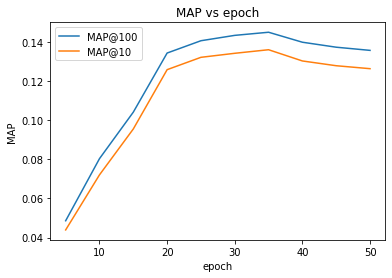

In [27]:
import matplotlib.pyplot as plt

num_validation_runs = len(dge_ann_history.history["val_map_100"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, dge_ann_history.history["val_map_100"], label="MAP@100")
plt.plot(epochs, dge_ann_history.history["val_map_10"], label="MAP@10")
#plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("MAP vs epoch")
plt.xlabel("epoch")
plt.ylabel("MAP");
plt.legend()

In [13]:
query_dcn_model = QueryModel(
    deep_model_layer_sizes=deep_layer_sizes, 
    use_cross_layer=True, 
    position_embeddings='absolute', 
    embedding_type='neighbor',
    embedding_dim=embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(item_embeddings),
    known_items_relations=adjacency_matrix,
    sequence_length=10)

candidate_model = tf.keras.models.Sequential([
    PlainEmbeddingModel(
      feature_name="target_product_id", 
      embedding_dim=embedding_dim,
      feature_type=items_feature_type, 
      feature_vocab=items_vocab,
    ),
    tf.keras.layers.GlobalAveragePooling1D()
])

dge_ann_dcn_model = RetrievalModel(
      query_model=query_model,
      candidate_model=candidate_model,
      candidate_pool=tf.data.Dataset.from_tensor_slices({"target_product_id": items_vocab[..., np.newaxis]})
    )

In [14]:
dge_ann_dcn_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))

dge_ann_dcn_history = dge_ann_dcn_model.fit(
    train_dataset,
    validation_data=test_dataset,
    validation_freq=5,
    epochs=50,
    verbose=1)

Epoch 1/50
42/42 [==============================] - 359s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6785.0440 - regularization_loss: 0.0000e+00 - total_loss: 6785.0440
Epoch 2/50
42/42 [==============================] - 349s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6319.2999 - regularization_loss: 0.0000e+00 - total_loss: 6319.2999
Epoch 3/50
42/42 [==============================] - 349s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6005.6652 - regularization_loss: 0.0000e+00 - total_loss: 6005.6652
Epoch 4/50
42/42 [==============================] - 347s 8s/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e

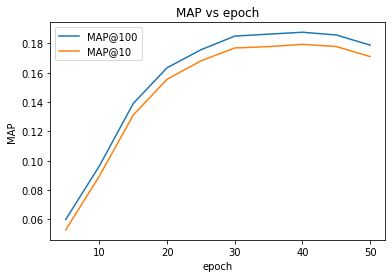

In [16]:
import matplotlib.pyplot as plt

num_validation_runs = len(dge_ann_dcn_history.history["val_map_100"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, dge_ann_dcn_history.history["val_map_100"], label="MAP@100")
plt.plot(epochs, dge_ann_dcn_history.history["val_map_10"], label="MAP@10")
#plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("MAP vs epoch")
plt.xlabel("epoch")
plt.ylabel("MAP");
plt.legend()

In [21]:
class LSTMQueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, 
               deep_model_layer_sizes: tp.List[str], 
               embedding_dim: int,
               **embedding_kwargs,
               ):
    """Model for encoding user queries.

    Args:
      deep_model_layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()
    # We first use the user model for generating embeddings.
    self.user_model = PlainEmbeddingModel(
        feature_name="user_id", 
        feature_type=users_feature_type, 
        feature_vocab=users_vocab, 
        embedding_dim=embedding_dim)
    self.event_type_model = tf.keras.models.Sequential(
        [
         PlainEmbeddingModel(
          feature_name="event_type", 
          feature_type=events_feature_type, 
          feature_vocab=events_vocab, 
          embedding_dim=embedding_dim,
          ),
         tf.keras.layers.GlobalAveragePooling1D()
        ]
        )
    self.item_history = LSTMEmbeddingModel(
        feature_name="product_id", 
        feature_type=items_feature_type, 
        feature_vocab=items_vocab, 
        embedding_dim=embedding_dim,
        num_recurrent_units=embedding_dim,
        **embedding_kwargs)
    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential()

    # Use the ReLU activation for all but the last layer.
    for layer_size in deep_model_layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in deep_model_layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    user_embedding = self.user_model(inputs)
    event_type_embedding = self.event_type_model(inputs)
    user_history_embeddings = self.item_history(inputs)
    feature_embedding = tf.concat([
        user_embedding,
        event_type_embedding,
        user_history_embeddings
    ], axis=1)
    return self.dense_layers(feature_embedding)

In [39]:
query_lstm_model = LSTMQueryModel(
    deep_model_layer_sizes=deep_layer_sizes, 
    embedding_dim=embedding_dim,
    )
candidate_model = tf.keras.models.Sequential([
    PlainEmbeddingModel(
      feature_name="target_product_id", 
      embedding_dim=embedding_dim,
      feature_type=items_feature_type, 
      feature_vocab=items_vocab,
    ),
    tf.keras.layers.GlobalAveragePooling1D()
])

lstm_model = RetrievalModel(
      query_model=query_lstm_model,
      candidate_model=candidate_model,
      candidate_pool=tf.data.Dataset.from_tensor_slices({"target_product_id": items_vocab[..., np.newaxis]})
    )

In [40]:
query_lstm_model.item_history.embedding_layer.embeddings_initializer = tf.keras.initializers.Constant(item_embeddings)

In [41]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.001))

lstm_history = lstm_model.fit(
    train_dataset,
    validation_data=test_dataset,
    validation_freq=5,
    epochs=50,
    verbose=1)

Epoch 1/50
42/42 [==============================] - 4s 11ms/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6956.3505 - regularization_loss: 0.0000e+00 - total_loss: 6956.3505
Epoch 2/50
42/42 [==============================] - 0s 9ms/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6930.2241 - regularization_loss: 0.0000e+00 - total_loss: 6930.2241
Epoch 3/50
42/42 [==============================] - 0s 9ms/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00 - loss: 6870.3468 - regularization_loss: 0.0000e+00 - total_loss: 6870.3468
Epoch 4/50
42/42 [==============================] - 0s 9ms/step - map_1: 0.0000e+00 - map_10: 0.0000e+00 - map_100: 0.0000e+00 - ndcg_1: 0.0000e+00 - ndcg_10: 0.0000e+00 - ndcg_100: 0.0000e+00

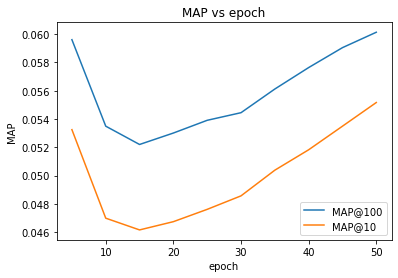

In [42]:
num_validation_runs = len(lstm_history.history["val_map_100"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, lstm_history.history["val_map_100"], label="MAP@100")
plt.plot(epochs, lstm_history.history["val_map_10"], label="MAP@10")
#plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("MAP vs epoch")
plt.xlabel("epoch")
plt.ylabel("MAP");
plt.legend()

In [43]:
import matplotlib.pyplot as plt

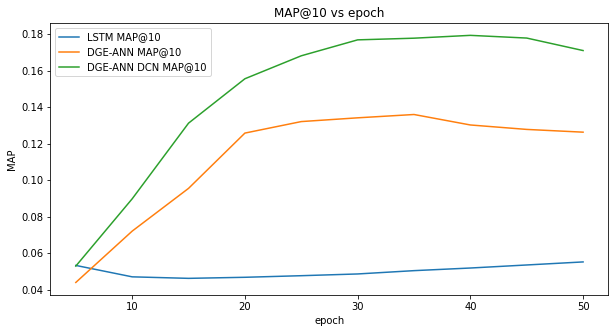

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, lstm_history.history["val_map_10"], label="LSTM MAP@10")
plt.plot(epochs, dge_ann_history.history["val_map_10"], label="DGE-ANN MAP@10")
plt.plot(epochs, dge_ann_dcn_history.history["val_map_10"], label="DGE-ANN DCN MAP@10")

plt.title("MAP@10 vs epoch")
plt.xlabel("epoch")
plt.ylabel("MAP");
plt.legend()
plt.show()

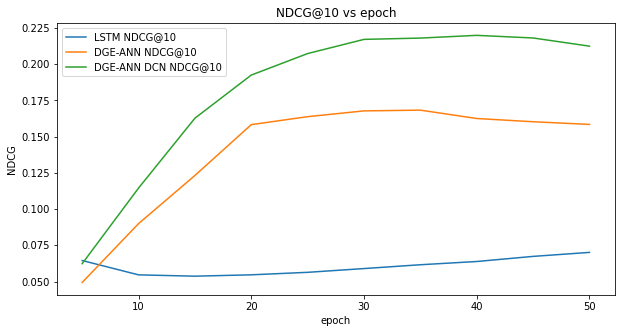

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, lstm_history.history["val_ndcg_10"], label="LSTM NDCG@10")
plt.plot(epochs, dge_ann_history.history["val_ndcg_10"], label="DGE-ANN NDCG@10")
plt.plot(epochs, dge_ann_dcn_history.history["val_ndcg_10"], label="DGE-ANN DCN NDCG@10")

plt.title("NDCG@10 vs epoch")
plt.xlabel("epoch")
plt.ylabel("NDCG");
plt.legend()
plt.show()